# EEG/MEG signal preprocessing

#### Max Planck School of Cognition, Methods in Cognitive Neuroscience, July 2022


##### Contact: Mina Jamshidi Idaji @ Neurology Dept., MPI CBS, Leipzig, Germany, jamshidi@cbs.mpg.de


### Objectives

There are a number of automatic pipelines for denoising EEG/MEG; however, in many cases you should inspect your data manually. Therefore, the objectives of this notebook are:
* Getting to know the usual artifacts in EEG/MEG recordings.
* Going through a typical manual pipeline for cleaning EEG/MEG data from usual artifacts.
* There can be also side objectives for this tutorial: this is a good chance to deepen your Python skills. So, in case you have limited experience with Python, don't worry at all. I tried to explain coding details as well. If you are already familiar with Python, you can skip the "Coding Detail" sections.

### In this tutorial:

* you will explore the MNE Python object Raw, which includes the sensor-space M/EEG data
* the following steps of pre-processing are covered in this tutorial: power-line noise cancellation, bad segments and channels

### In the next tutorial:
* you will learn the ICA artifact rejection
* finalizing the EEG pre-processing pipeline.

--------------

### Packages

There are three main packages that we will use here:
* <a href='https://mne.tools/stable/index.html'>MNE Python</a> is an open-source python toolboxes for analysing electrophysiological signals. MNE Python provides the users with very comprehensive tutorials. There is also an active mailing list for it. There, you can ask your questions and the developers actively respond.

* The *signal* module of Scipy is the toolbox for signal processing. I would call it a Python version of MATLAB! ;-) To my best of experience, almost all useful signal processing matlab functions are implemented in scipy.signal with similar name and syntax. 

* Numpy (and Scipy) are the two basic Python packages that you should learn to work with. Numpy is designed for working with matrices in Python. 



--------------

### Data
* We use EEG data of LEMON dataset [2], a public dataset collected at MPI CBS. The dataset includes resting-state EEG recordings, which consist of 16, inter- leaved, one-minute blocks of eyes-closed (EC) and eyes-open (EO) conditions. In this tutorial, we want to work with EC condition. We will see how we can extract these data segments.



--------------

### Important Note #1

In this notebook, I have aimed to guide you through the data, from the stage you load it to the last stage where it is cleaned. The notebook is arranged in two sections:

* Section 1: *Loading the data: The raw class*

When you load data using MNE Python, it is loaded as a Raw object. For those of you who plan to work with such data, I find it crucial to get to know what each of the attributes of a Raw object mean. Therefore, in section 1 we will take a look at some of the most important attributes of the raw object. In the interest of time, we will skip this section in our hands-on session. However, please take your time to go through this section.
    
* Section 2: Artifacts
    
In this section, we will see what kind of artifacts are detectable in EEG data and how to clean them. We will go through this section together in the hands-on session. The only exception is the part of the notebook that we extract the eye-closed condition of the data. I'll skip that part in our session. 
    

> Although we'll skip some parts of the notebook in the hands-on session, you can go through them when you work through the tutorial on your own. You can always contact me via email and ask your questions. 

### Note #2

If you will work with neuroimaging data, at some point you have to work with some programming language. If you find it challenging to write the exercises of this notebook, do not become disappointed: check the links I provided you, google your questions, etc. Although we have provided you with the answers of the exercises, I do encourage you to spend time to complete them by yourself. It may turn out that you have to spend a couple of hours for this tutorial, but based on my experience, I promise you if you do it yourself and try to understand most of the code lines, your next Python-based tutorial experience will be much smoother.

### Note #3

In order to make this notebook a bit simpler, you are provided with a couple of *help function*. These self-written functions can help us to skip the details of how to do some steps. However, I encourage you to take a look at the content of these functions and ask your quesitons if you have any.

### Note #4

In order to be able to run interactive matplotlib plots in jupyter hub, we have to set the backend of the matplotlib package to notebook. <a href="https://github.com/matplotlib/ipympl">ipympl</a> should be installed. Then, this can be achieved by:

    %matplotlib widget

Note: If you are running the notebook on your local machine, the backend tk is prefered. You can set it by:

    %matplotlib tk
    
In order to go back to inline plotting (without interactive figures), you can write:

    %matplotlib inline

### Note #5

You are supposed to compute all steps yourself! There are saved versions of raw files at interim stages, which you could load. But as the first goal, run everything yourself!

--------------
--------------

## Introduction 

When recording any data (in general), we always record some unwanted signals (known as artifact or noise)  along with the signal of interest. For example: think a microphone that wants to record the voice of a person in a crowded room, this microphone records the voice of the the target person (= the signal of interest) as well of all other voices in the environment (=artifacts), e.g. other people's voice, or the music being played, or the voice of an ambulance that passes the street! Therefore, the first step of signal processing is to clean the recorded data from artifacts: that's called artifact removal or denoising.

Artifacts in electrophysiology data can result from biological or environmental sources. Head movement, eye movement, eye blinks and heart activity are examples of biological artifact sources. The most prominent environmental noise is line noise, which is due to power-line: in Europe 50 Hz, in the US 60 Hz. We will inspect these noise sources in our data later.

Cleaning data is done by either removing a whole data segment contaminated by noise, or by separating the noise from signal of interest and removing the noise source signal only. We see both cases in this tutorial.

<font color='gray'>
    
#### Coding Detail: Importing Packages
In order to be able to use different features of Python, it is necessary to install and import the relevant packages. For example, the package `numpy` can be used to work with matrices in Python. Importing a package is quite simple. We use `import` to import the package and also use `as` to give it a name. Each package has its own functions. To use this functions later in the code, it is necessary to use the following format `np.` + `name of the function`.

You may simply import the package by `import [PackageName]`, for example `import numpy`. In this case, the package does not have a *nickname* (e.g. `np`) any more. You should call it by its original name, for example `numpy.[FunctionName]`. We usually do this when the package name is already a short one.
There are cases that you want to use a function of a package directly in your code. In such a case, you should import the function directly by writing `from [PackageName] import [FunctionName]`. For example, `from numpy import pi` can be used when you want to use `pi` instead of `np.pi`. This practice is used when you use a function multiple times in your code, or when you do not need all the functions of a package, but only a couple of them. Another example of importing multiple funtions from a package: `from numpy import pi, dot, mean`. We tend to import the whole package; however, a more professional way is to import only the functions that we need - if they are not many. 

NOTE: BEFORE STARTING INSTALL MNE FROM TERMINAL. CHECK JupyterHub.pdf.

In [1]:
import mne  # MNE Python
from os.path import join  # this function is used to build the directories 
import numpy as np  # numpy is a library for working with matrices
import scipy.signal as sp  # scipy.signal implements the signal processing functions
# import matplotlib
# matplotlib.use('TKAgg')
from matplotlib import pyplot as plt  # matplotlib is the most common used package to do plotting in Python
from IPython.display import Video, Image
import eeg_tutorial_help_functions as hf  # help functions for this tutorial

# the backend of matplotlib for plotting interactive plots in jupyter notebook on jupyter hub of GWDG
%matplotlib widget  


--------------
--------------

# 1. Loading the data: The raw class

In this section we will load the data using MNE Python and get to know some attibutes of  <a href="https://mne.tools/dev/generated/mne.io.Raw.html#mne.io.Raw.plot_psd">Raw</a> class of this package. 

Now we are ready to read the data. Note that for data of different devices, you may use different functions [3].

In [2]:
subject = 'sub-010088'
path_data = '../public/0579223/MCNcourse2022/EEG/'

In [3]:
vhdr_fname = join(path_data, subject, subject + '.vhdr')  # build the directory of the data
# vhdr_fname = path_data + subject + '/' + subject + '.vhdr'  # this is an alternative to os.path.join


raw_orig = mne.io.read_raw_brainvision(vhdr_fname, preload=True)  # load the data
print(raw_orig)  # take a look at what we loaded

Extracting parameters from ../public/0579223/MCNcourse2022/EEG/sub-010088/sub-010088.vhdr...
Setting channel info structure...
Reading 0 ... 2702599  =      0.000 ...  1081.040 secs...
<RawBrainVision | sub-010088.eeg, 62 x 2702600 (1081.0 s), ~1.25 GB, data loaded>


<font color='gray'>

#### Coding Detail: Strings

* Strings in Python are surrounded by single quotation marks, or double quotation marks.
    * Example: ` 'Hi' ` or ` "Hi" `.
* Two strings can be combined using the plus operands.
    * Example: ` 'Hello' + 'World!' ` results in a single string object ` 'Hello World!' `
* A number can be converted to a string using `str()`.
    * Example: `str(2)` results in `'2'`

Continuous EEG data is loaded as a <a href="https://mne.tools/dev/generated/mne.io.Raw.html#mne.io.Raw.plot_psd">Raw</a> object. If you want to take a closer look at the raw object, try `print(vars(taw_orig))`:

In [4]:
print(vars(raw_orig))

{'_last_samps': array([2702599]), '_first_samps': array([0]), 'info': <Info | 7 non-empty values
 bads: []
 ch_names: Fp1, Fp2, F7, F3, Fz, F4, F8, FC5, FC1, FC2, FC6, T7, C3, Cz, ...
 chs: 62 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 1000.0 Hz
 meas_date: 2014-05-09 10:18:05 UTC
 nchan: 62
 projs: []
 sfreq: 2500.0 Hz
>, 'buffer_size_sec': 1.0, '_cals': array([1.e-07, 1.e-07, 1.e-07, 1.e-07, 1.e-07, 1.e-07, 1.e-07, 1.e-07,
       1.e-07, 1.e-07, 1.e-07, 1.e-07, 1.e-07, 1.e-07, 1.e-07, 1.e-07,
       1.e-07, 1.e-07, 1.e-07, 1.e-07, 1.e-07, 1.e-07, 1.e-07, 1.e-07,
       1.e-07, 1.e-07, 1.e-07, 1.e-07, 1.e-07, 1.e-07, 1.e-07, 1.e-07,
       1.e-07, 1.e-07, 1.e-07, 1.e-07, 1.e-07, 1.e-07, 1.e-07, 1.e-07,
       1.e-07, 1.e-07, 1.e-07, 1.e-07, 1.e-07, 1.e-07, 1.e-07, 1.e-07,
       1.e-07, 1.e-07, 1.e-07, 1.e-07, 1.e-07, 1.e-07, 1.e-07, 1.e-07,
       1.e-07, 1.e-07, 1.e-07, 1.e-07, 1.e-07, 1.e-07]), '_raw_extras': [{'offsets': None, 'fmt': 'short', 'order': 'F', 'n_sampl

The <a href="https://mne.tools/dev/generated/mne.Info.html#mne.Info">info</a> attribute of raw object includes the important information about the recording. Let's take a closer look at this dictionary: 

In [5]:
print(raw_orig.info)

<Info | 7 non-empty values
 bads: []
 ch_names: Fp1, Fp2, F7, F3, Fz, F4, F8, FC5, FC1, FC2, FC6, T7, C3, Cz, ...
 chs: 62 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 1000.0 Hz
 meas_date: 2014-05-09 10:18:05 UTC
 nchan: 62
 projs: []
 sfreq: 2500.0 Hz
>


Here are the descriptions of some attributes of Info dictiobary:

* bads: A list of the names of bad channels.
* ch_names: a list of channel names .
* chs: A list of dictionaries including the detailed information of the channels.
* highpass: Highpass corner frequency in Hertz. Zero indicates a DC recording.
* lowpass: Lowpass corner frequency in Hertz.
* nchan: number of channels.
* sfreq: sampling frequency in Herz. 

Info is actually a class of MNE. But it behaves like a dictionary. Therefore, you can extract its attribute for example like `raw_orig.info['sfreq']`. 

<font color='gray'>
    
#### Coding Detail: Dictionaries

Among many websites, you can read <a href="https://www.geeksforgeeks.org/python-dictionary/">here</a> or <a href="https://realpython.com/python-dicts/">here</a> to learn what are dictionaries in Python and how to work with them. 

<font color='gray'>

#### Coding Detail:
    
* You can read the attributes of a class using `.`: for example `info` is an attribute of `raw_orig` and we can read it with `raw_orig.info'. Every 

* Classes have functions that are directly applied on them using `.`, these function are called methods. For example, you can extract the data matrix of raw object using method `get_data()` by `raw_orig.get_data()`.

**Disscussion 1**: Looking at `raw_orig.info`, could you explain the rationale of why the low-pass frequency is at 1000 Hz?

Hint: think about nyquist rate.

**YOUR Notes:** (type your notes here if you want)

Now, let's extract the data for the raw object and take a look at its dimensions.

In [6]:
data_orig = raw_orig.get_data()  # extract the data using method get_data()
print('the shape of the data matrix is ', data_orig.shape)  # print the shape (details about .shape bellow)

the shape of the data matrix is  (62, 2702600)


<font color='gray'>

#### Coding Detail: ndarray.shape

* You can get the shape of a numpy array by `.shape`. For example, if `x` is a 2-D numpy array with dimensions $5\times 10$, `x.shape` returns a tuple equal to `(5, 10)`. You can refer to the first and second dimensions by `x.shape[0]` and `x.shape[1]`.

* You can read about tuples in google, for example <a href='https://www.geeksforgeeks.org/tuples-in-python/'>here</a>.

<font color='gray'>

#### Coding Detail: Indexing in Python
In Python (like some other languages), indexing of arrays starts with 0.

Each member of an array has its own index. Indexing can be from left to right starting from 0 or from right to left from -1:

    x = [1, 2, 3, 4, 5]
    idx  0  1  2  3  4
    idx -5 -4 -3 -2 -1

It is important to note that index -4 is exactly the same as index 1 for Python in this example. Based on this negative indexing, you can get the last elemtns of an array or a list by index -1, e.g. `x[-1]`.
    

Besides, if we want to extract a part of a matrix, we don't have to give any steps if we choose the order of the indexes from left to right, unless we want a step bigger than one. the general syntax is `x[start:end:step]`

> `x[0:3]` returns `[1, 2, 3]` corresponding to indices `0, 1, 2`
    
> `x[0:5:2]` returns `[1, 3, 5]` corresponding to indices `0, 2, 4`
    
But if our indexes are from right to left, we must give the step -1 or a smaller negative integer. 

> `x[-2:-5:-1]` returns `[4, 3, 2]`
    
It is also worth mentioning that Python will continue to one index before the given index. For example 0:3 includes the indices 0, 1, 2.

**EXERCISE 1:**

* How long is the duration of the recording?
 
      Hint: You can either use the `times` attribute of `raw_orig` or use the number of samples and sampling rate to compute the duration of the recording.
      Hint: the sampling frequency is given in the following attribute of `raw_orig`
              raw_orig.info['sfreq']


* How many channels does the recording have?
        Hint: You can either use the dimensions of `data_orig` or use one of the attributes of `raw_orig.info`

**YOUR ANSWER:**  (type your answer in the cell below.)

In [7]:
# TO BE COMPLETED BY STUDENTS  -------------------
duration_1 = ? # take the last element of times attribute of raw_orig
duration_2 = ? # number of samples is equal to sampling rate multiplied by the duration in seconds. 
# Now you have the sampling rate and the number of samples, compute the duration.
number_of_channels = ? # You have this value in info attribute of raw class
#---------------------------------------------------
print('Using the _times attribute, the duration of the recording is: ', duration_1/60, '(min)')
print('Using the number of smaples and sampling rate, the duration of the recording is: ', duration_2/60, '(min)')
print('Number of channels = ', number_of_channels)

SyntaxError: invalid syntax (288294168.py, line 6)

The sampling rate of our data is 2500Hz. Based on Nyquist theorem, this sampling frequency can let us reconstruct up to 1250Hz (Actually, that's why the initial lowpass filter is set to lower than 1250 to make sure no aliasing happens). If the activity of our interest has a maximum frequency of $f_{max}$, we can reduce the sampling rate to at least $2f_{max}$. This helps to reduce the number of data samples and helps to speed up processing steps. 

In our case, we are working with resting-state data and we are not interested in very high frequency activity. We reduce the sampling rate to 250Hz. We do so using the `resample` method of the raw object. Note that the `resample` function of `scipy.signal` can be also used in case you don't want to use MNE functions. 

In [8]:
raw_resamp = raw_orig.copy()
raw_resamp.resample(sfreq=250)  # resample data to 250Hz.
resamp_fname = join('./Data', subject, subject + '-resample-raw.fif')
#resamp_fname = join('./Data', subject, subject + '-resample-raw.fif')
#raw_resamp.save(resamp_fname)

If you want to load pre-computed resampled data, execute the following cell:

In [9]:
resamp_fname = join(path_data, subject, subject + '-resample-raw.fif')
raw_resamp = mne.io.read_raw_fif(resamp_fname)  # read the saved version resampled data

Opening raw data file ../public/0579223/MCNcourse2022/EEG/sub-010088/sub-010088-resample-raw.fif...
Isotrak not found
    Range : 0 ... 270259 =      0.000 ...  1081.036 secs
Ready.


Now let's look at the number of samples of the resampled data and compare it with the original data:

In [10]:
print('number of samples of resampled data = ', str(raw_resamp.n_times))
print('number of samples of original data = ', str(raw_orig.n_times))

number of samples of resampled data =  270260
number of samples of original data =  2702600


You can see that we decreased the sampling rate from 2500Hz to 250Hz (i.e. 1/10), and the number of samples of resampled data are also 1/10 of the number of samples of the original data. 

<font color='gray'>

#### Coding Detail: the copy() method

While some methods of the classes are applied to the object directly, some other make a copy of the object and make the changes on the copy. In the latter case, the original object does not change; however, in the former case, the original object changes. In order to make a copy of an object and keep the original object untouched, the method `copy()` is defined and used for many classes. 

In the very example in the cell above for resampling: the method `resample` of raw class is applied on the object directly. Therefore, if we do not use the `copy()` method to generate a copy of the `raw_orig` object, after the resampling, the `raw_orig` variable changes. In this tutorial, we want to keep all the versions of data so that we can refer to them again.

Whenever there are events happening during the recording, those events should be saved in the data structure. Why? Because we need to correspond their occurrence to our data samples. These events may be stimuli (event-related activity) or in our case the *notification* of closing and opening the eyes. The onset and duration of these events are saved in the `_annotations` attribute of the raw object. The function `events_from_annotations` from the mne library extracts the events from a raw object. We use this event matrix later for extracting the data related to EC condition.

In [11]:
events_ = mne.events_from_annotations(raw_resamp, event_id=None)  # extract the events

print(events_)
events_mat = events_[0]  # save the information of the onset and description of the events in a new variable for the later usage.
print(events_mat[:, -1])


Used Annotations descriptions: ['Comment/no USB Connection to actiCAP', 'New Segment/', 'Stimulus/S  1', 'Stimulus/S200', 'Stimulus/S210']
(array([[     0,      0,      2],
       [     0,      0,      1],
       [  1931,      0,      3],
       ...,
       [266263,      0,      4],
       [266763,      0,      4],
       [267263,      0,      4]]), {'Comment/no USB Connection to actiCAP': 1, 'New Segment/': 2, 'Stimulus/S  1': 3, 'Stimulus/S200': 4, 'Stimulus/S210': 5})
[2 1 3 3 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 3 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 3 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 3 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 3 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 3 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 3 5 5 5 5 5 5 5

We want to exclude the EOG channels for the further analysis. The `pick` method of the raw class helps to select the parts using `pick_types` function. So, we omit the VEOG channels by marking it as a bad channel and then excluding the bad channels from data.

In [12]:
raw_resamp.info['bads'] = ['VEOG']  # add the VEOG channel to the bad channel list of raw_resamp
picks = mne.pick_types(raw_resamp.info, meg=False, eeg=True, exclude='bads', chpi=True)  # select the properties that we wanna select form raw_resamp. We want EEG channels and to exclude the bad channels.
raw1 = raw_resamp.copy()  # raw1 will include the resampled data with VEOG channel excluded.
raw1.load_data()
raw1.pick(picks=picks)  # Select the desired properties

Reading 0 ... 270259  =      0.000 ...  1081.036 secs...


<Raw | sub-010088-resample-raw.fif, 61 x 270260 (1081.0 s), ~125.8 MB, data loaded>

The data that we loaded does not contain the channel locations. If the channel locations are measured during the recording, we should read them and put them inside the raw object. Here, we use the standart channel locations:

In [13]:
montage = mne.channels.make_standard_montage('standard_1005')  # get the standard montage
raw1.set_montage(montage)  # set the montage of raw1 to the standard one
raw1.set_eeg_reference(projection=True)  # average referencing

Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.


<Raw | sub-010088-resample-raw.fif, 61 x 270260 (1081.0 s), ~125.9 MB, data loaded>

Now, let's take another look at the info attribute of the raw object:

In [14]:
print(raw1.info)

<Info | 11 non-empty values
 bads: []
 ch_names: Fp1, Fp2, F7, F3, Fz, F4, F8, FC5, FC1, FC2, FC6, T7, C3, Cz, ...
 chs: 61 EEG
 custom_ref_applied: False
 dig: 64 items (3 Cardinal, 61 EEG)
 file_id: 4 items (dict)
 highpass: 0.0 Hz
 lowpass: 125.0 Hz
 meas_date: 2014-05-09 10:18:05 UTC
 meas_id: 4 items (dict)
 nchan: 61
 projs: Average EEG reference: off
 sfreq: 250.0 Hz
>


If you compare `raw1.info` and `raw_orig.info`, you see that after adding the channel locations, a new field, `'dig'`,  is added to the info attribute of `raw1`. the `'dig'` field contains the information about the location of the sensors and other important head points.

---
---

## 2. Artifacts

### 2.1. Power-line noise

The first steps of screening EEG data are to look at the power spectral density (PSD) of data and then the time series of data. Let's take a look at the PSD of our data:

Effective window size : 1.024 (s)


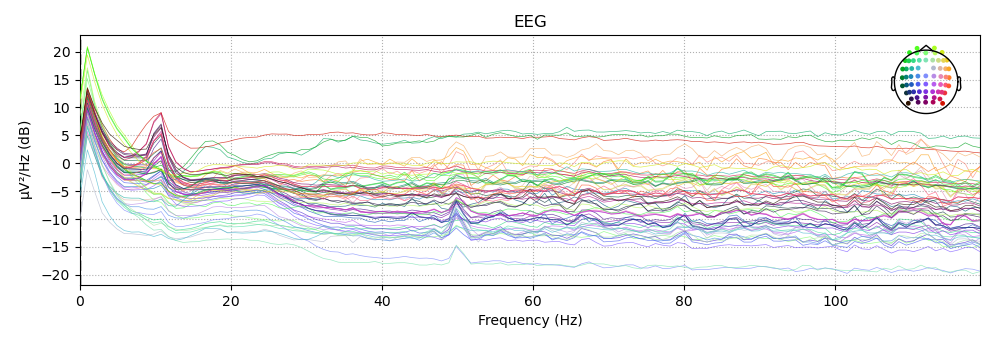

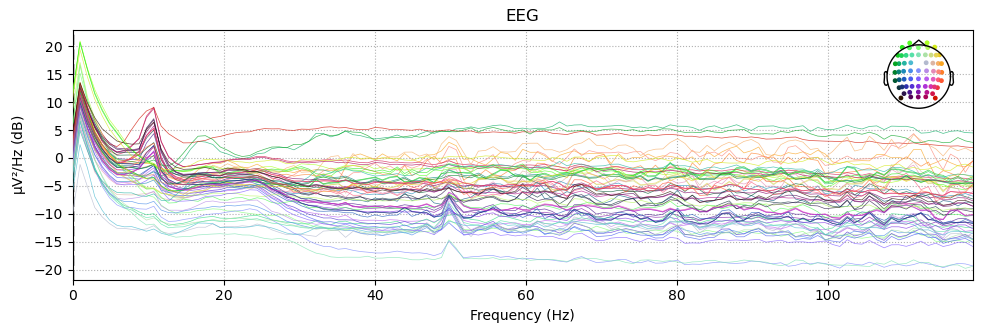

In [15]:
%matplotlib widget
freq_res = 1  # frequency resolution
nfft = (2 ** np.ceil(np.log2(raw1.info['sfreq'] / freq_res))).astype(int)  # number of fast fourier transform (fft) points
raw1.plot_psd(fmin=0, fmax=120, n_fft=nfft, picks='all')  # calculate and plot PSD

Each line in the figure above represents the PSD of one channel. The raw class provides us with the nice visualization tool for PSD in the method `plot_psd`. 

The first noise component that is clear already on the PSD is the power-line noise. This noise is at 50Hz in Europe and 60Hz in the US. Therefore, based on the place of recording the frequency of power-line noise may change. You can see the little bumps at 50Hz. Look at the PSD of one of the channels. Here, instead of using the built-in MNE method for computing PSD, we use the `scipy.signal.welch` function, which is the function that MNE uses as well. `scipy.signal.welch` computes the PSD of the input multi-channel signal. The PSD is traditionally plotted in dB scale.

/opt/conda/lib/python3.9/site-packages/matplotlib/patches.py:1444: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self.verts = np.dot(coords, M) + [


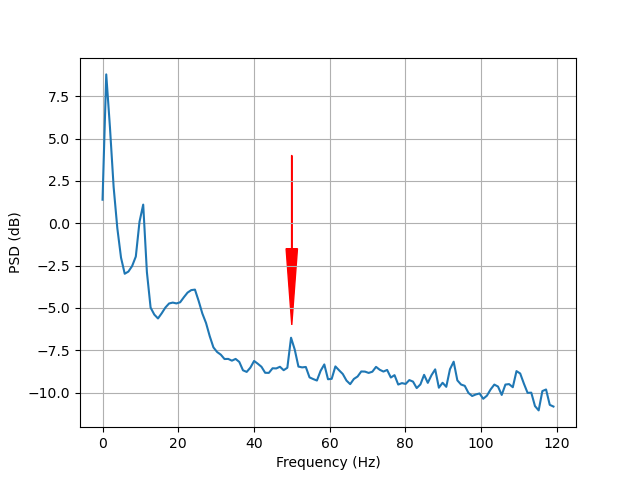

In [16]:
ax = hf.plot_psd(raw1.get_data()[54, :]*1e6, raw1.info['sfreq'], freq_res=1, f_max=120) # plot the psd
ax.arrow(x=np.array([50]), y=4, dx=0, dy=-10, color='red',
                     width=0.1, head_width=3, length_includes_head=True)

We should filter the power-line noise. 
* Notch-filter at 50Hz: A notch filter passes the signal at all frequencies except the specified frequency band. If we notch filter at 50Hz, the rest of the signal content is not touched. This approach should be followed when the signal of interest has high-frequency components (e.g. high gamma waves) 

Below, we look at the frequency-response of two filters. First we start with the bandpass filtering of one channel (P2): 

/home/jovyan/MPSCog-MCN2021/eeg_tutorial_help_functions.py:69: RuntimeWarning: divide by zero encountered in log10
  plt.plot(f, 10 * np.log10(abs(h)))


Text(0.5, 1.0, 'PSD of channel P2 before and after bandpass filtering')

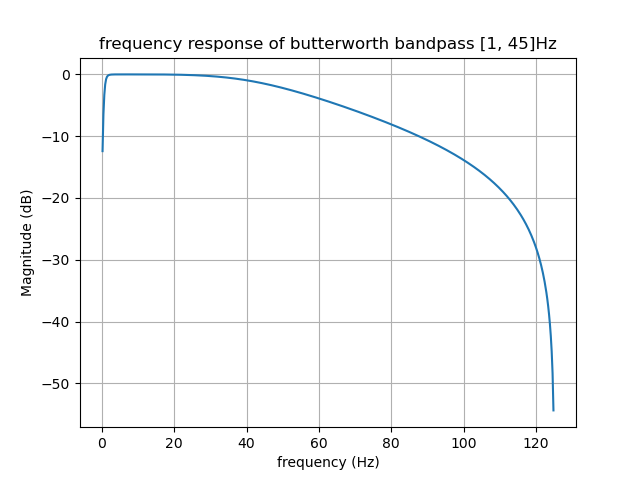

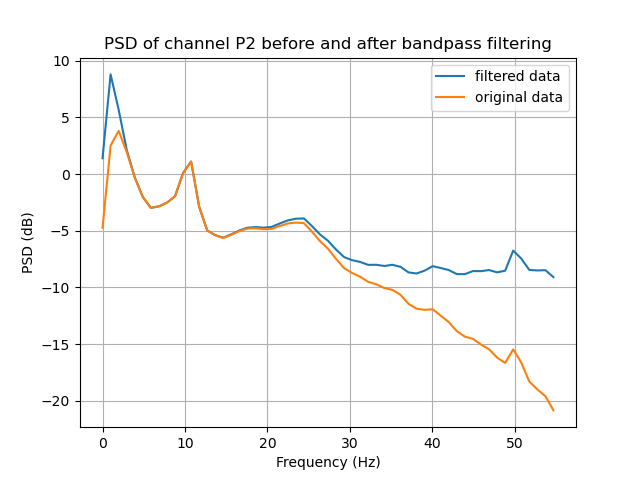

In [17]:
# %matplotlib inline
fs =  raw1.info['sfreq']  # sampling frequency
data1_bp = hf.bandpass_filter_raw_plot(raw1.get_data()[54:55, :], fs, 1, 45)
data2 = np.append(raw1.get_data()[54:55, :], data1_bp, axis=0)  # concatenate the original and filtered data, so that we can take a look at their PSDs together
ax = hf.plot_psd(data2*1e6, fs, freq_res=1, f_max=55) # plot the psd
ax.legend({'original data', 'filtered data'})
plt.title('PSD of channel P2 before and after bandpass filtering')

As you see the signal content at frequencies higher than 45 is attenuated dramatically. Now let's look at a notch filter at 50Hz:

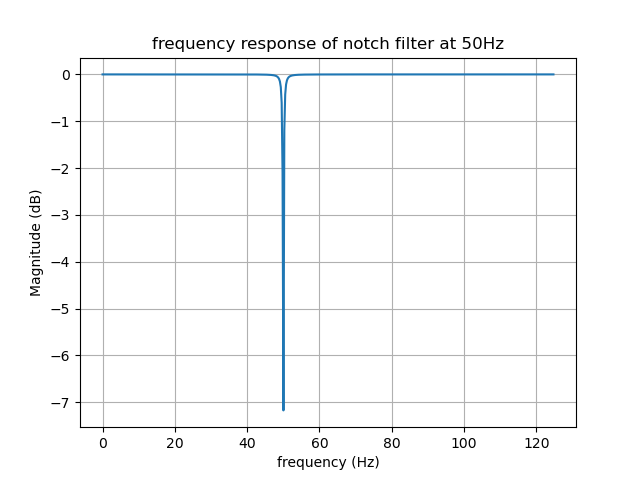

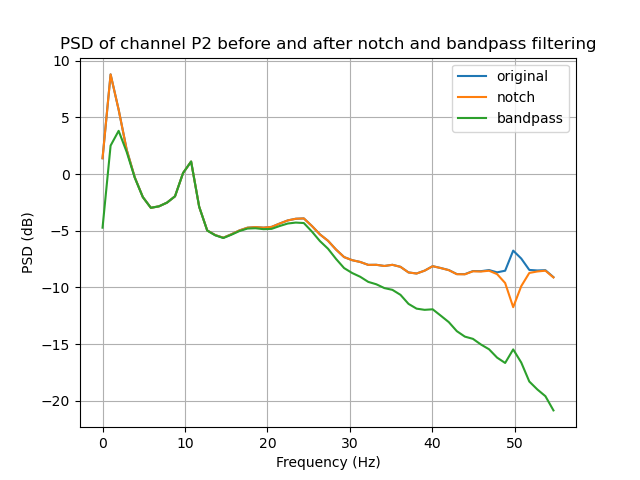

In [19]:
fs = raw1.info['sfreq']
data1_n = hf.notch_filter_raw_plot(raw1.get_data()[54:55, :], fs, 50)
data2 = np.concatenate((raw1.get_data()[54:55, :], data1_n, data1_bp), axis=0)
ax = hf.plot_psd(data2*1e6, fs, freq_res=1, f_max=55)
plt.title('PSD of channel P2 before and after notch and bandpass filtering')
ax.legend(['original', 'notch', 'bandpass'])

You can see that the notch filter only omits the signal content at the specified frequency. 

For the rest of this tutorial we first do notch filter at 50Hz and then bandpass filter the signal, because here we have resting-state data and we aren't interested in higher frequency content. In the following, we use the built-in method of raw class for filtering.

In [20]:
iir_params = dict(order=2, ftype='butter')  # parameters of the iir filter: butterwirth bandpass filter order 4. 
raw1.load_data()
raw1.notch_filter(freqs=np.array([50]), method='iir', iir_params=iir_params)  

Setting up band-stop filter from 49 - 51 Hz

IIR filter parameters
---------------------
Butterworth bandstop zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoffs at 49.38, 50.62 Hz: -6.02, -6.02 dB



<Raw | sub-010088-resample-raw.fif, 61 x 270260 (1081.0 s), ~125.9 MB, data loaded>

In [21]:
iir_params = dict(order=2, ftype='butter')  # parameters of the iir filter: butterwirth bandpass filter order 4. 
raw1.filter(l_freq=1, h_freq=45, method='iir', iir_params=iir_params)  # l_freq is the low-frequency cut-off, h_freq is the high-frequency cut-off

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 45 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoffs at 1.00, 45.00 Hz: -6.02, -6.02 dB



<Raw | sub-010088-resample-raw.fif, 61 x 270260 (1081.0 s), ~125.9 MB, data loaded>

Here, I would like to take your attention to the "two-pass forward and reverse" filtering. A filter is an array of coefficient which is convolved with the signal. This procedure can result in a phase shift in the signal. FIR filters have a constant phase shift, but IIR filters not. Therefore, for IIR filters we do a forward and backward filtering in order to compensate the phase shift. That's why it is called "zero-phase non-causal" filter. 

Now let's look at the new PSD:

Effective window size : 1.024 (s)


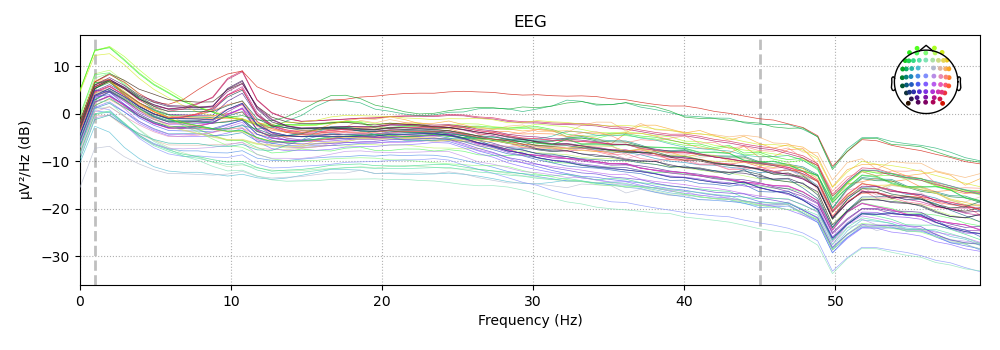

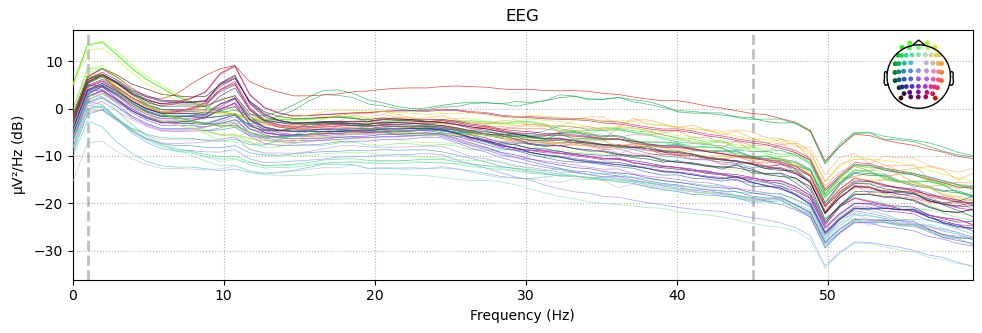

In [22]:
freq_res = 1
nfft = (2 ** np.ceil(np.log2(raw1.info['sfreq'] / freq_res))).astype(int)
raw1.plot_psd(fmin=0, fmax=60, n_fft=nfft, picks='all')

### Extracting EC condition data

#### For the sake of time in the hands-on session we skip this part. Please check it on your own:-)

As said before, this data consists of segments of eyes closed (EC) and eyes open (OP) conditions. We want to use EC condition. Therefore, we should cut the data. 

Why do we separate the EC and EO conditions?

* In EO condition the amount of eye-related artifacts is much more. Therefore, if we combine the EC and EO, we may miss some noise sources from EO, since those are not pronounced in EC. Or we may remove a lot variance from EC data, since a noise source from EO condition has driven inpendent component analysis (ICA, method used for denoising).
* These two conditions have different functional implications. For example, in EC condition alpha source signals are much stronger, in EO condition there is visual input. 

Function `extract_ec_condition` from the help funcitons of this tutorial selects the data related to this condition and returns a raw object which only includes the EC condition data.

In [23]:
raw = hf.extract_ec_condition(raw1) 
print(raw.n_times)

Used Annotations descriptions: ['Comment/no USB Connection to actiCAP', 'New Segment/', 'Stimulus/S  1', 'Stimulus/S200', 'Stimulus/S210']
duration of data=8.8094 (s)
Creating RawArray with float64 data, n_channels=61, n_times=132141
    Range : 0 ... 132140 =      0.000 ...   528.560 secs
Ready.
132141


In [ ]:
annot_onset = events_mat[:, 0]
annot_description = events_mat[:, -1]
# ---------------------------------------------
print(np.unique(annot_description))

The EC condition is marked with 5, while EO has the marker 4. Therefore, as far as a sample has marker 5, it is an EC condition. We want to separate the EC data segments. In order to find the onset of the EC condition, we first mark all the 5 events as one and all the other events as zero. With this trick, we can detect where the first 5 event happens and find the onset of EC condition. 

* First we make an array of zeros with the same shape as annot_description, call it ec_array.
* Then whereever annot_description is 5, we put a 1 in ec_array.  

<font color='gray'>

#### Coding Detail: numpy.zeros

* You can make an array of zeros using <a href='https://numpy.org/doc/stable/reference/generated/numpy.zeros.html'>`numpy.zeros`</a>. There are similar ways of making arrays of ones and empty array using `numpy.ones` and `numpy.empty`.

In [ ]:
ec_array = np.zeros(annot_description.shape)   # build an array of zeros with the same size as annot_description
# ---------------------------------------------

ec_array[annot_description==5] = 1
# %matplotlib inline
plt.figure()
plt.plot(ec_array)
plt.xlabel('sample number')
plt.ylabel('Condition (1= EC - 0=EO)')

What we see in the figure above is where (in which sample point) the EC condition starts and ends. Now we should do an *edge detection* to find where `ec_array` is one. If you think of it algorithmically, you see that if we subtract the `ec_array` value of each sample from its previous sample, we get zero at all samples except at the onsets of EC condition we get 1 and at the end of the EC condition we get -1. <a href='https://numpy.org/doc/stable/reference/generated/numpy.diff.html'>np.diff</a> computes the difference of the elements of its input array. 

In [ ]:
ec_array_diff = np.diff(ec_array) 
ind_start = np.where(ec_array_diff == 1)[0] + 1  # find the onset of EC -> where ec_array_diff is 1
ind_end = np.where(ec_array_diff == -1)[0] + 1   # find the end of EC -> where ec_array_diff is -1
if ind_end.shape[0] != ind_start.shape[0]:
    ind_end = np.append(ind_end, ec_array_diff.shape[0])
plt.figure()
plt.plot(ec_array)
plt.plot(ind_start, np.ones(ind_start.shape), 'r*')
plt.plot(ind_end, np.zeros(ind_end.shape), 'g*')

onset_ec = annot_onset[ind_start]  # the sample corresponding to onset of EC
duration_ec = annot_onset[ind_end] - onset_ec  # the duration of corresponding EC
plt.xlabel('sample number')
plt.ylabel('Condition (1= EC - 0=EO)')
plt.legend(['events', 'onset of EC', 'end of EC'])

Now that we detected the EC condition duration and starting samples, we can segment our data and extract these condition's data.

In [ ]:
data = raw1.get_data()  
ind_start_data = onset_ec
ind_end_data = annot_onset[ind_end]
n_ec_segments = ind_start.shape[0]
data_new = np.empty((data.shape[0],0))
for i_seg in range(n_ec_segments):
    data_new = np.append(data_new, data[:, ind_start_data[i_seg]:ind_end_data[i_seg]], axis=1)
print('duration of data=' + str(data_new.shape[1]/raw1.info['sfreq']/60) + ' (s)')
raw = mne.io.RawArray(data_new, raw1.info)

You see that we have almost 8min of EC data. Additionally, you see that we can make a new raw object using `mne.io.RawArray` if we have the data matrix (with the shape channel $\times$ sample) and the info structure.

<font color='gray'>

#### Coding Detail: for loop

In order to build a for loop you need a counter that *counts* the iterations. Counting does not mean that it has to go from 0 to n, but it means that any iteration should be identified using a counter value. The general for loop structure is like:

    for k in ...:
        # Do sth
        
In the above code, k is the counter and should go through some values in the iterations. There are different ways of producing these values based on how we wanna count the iterations. Here are some of the possible ways:

* range. it is used when you want to generate some integer values and go through them in the iterations. Besides many other websites, you can learn about it <a href='https://www.geeksforgeeks.org/python-range-function/'>here</a>.
* enumerate. it is used when you want to loop over a list or an array. check <a href='https://book.pythontips.com/en/latest/enumerate.html'>here</a> or <a href='https://www.geeksforgeeks.org/enumerate-in-python/'>here</a> for example.
* zip. it is used to loop over an aggregation of multiple arrays or lists. check <a href='https://www.geeksforgeeks.org/zip-in-python/'>here</a> or <a href='https://www.geeksforgeeks.org/zip-in-python/'>here</a> for details.

In order to keep the track of where a new segment starts we add the annotations to the new raw object.

In [ ]:
raw._annotations = mne.Annotations(onset_ec, duration_ec, ['new ec segment'] * n_ec_segments, 
                                     orig_time=raw.info['meas_date'])

In [ ]:
# ec_fname = join(path_data, subject, subject + '-ec-raw.fif')
# raw.save(ec_fname)

---

### 2.2. Artifacts: Bad segments and channels

In [24]:
raw = mne.io.read_raw_fif(path_data+subject + '/' + subject + '-ec-raw.fif')  # read the saved version of the data with only EC condition

Opening raw data file ../public/0579223/MCNcourse2022/EEG/sub-010088/sub-010088-ec-raw.fif...
    Read a total of 1 projection items:
        Average EEG reference (1 x 61)  idle
    Range : 0 ... 132140 =      0.000 ...   528.560 secs
Ready.


We cleaned the power-line noise by filtering. That was easy! ;-) The other noise sources are a bit harder to remove because they are entangled with brain signals and we want to do our best not to remove the precious brain activities, while cleaning the artifacts. This may look impossible at the first glance. But thanks to signal processing tools, we are able to *blindly* separate a lot of noise sources from our data effectively. Why *blindly*? Because we do not have a lot of information about the artifact sources; therefore, those source separation methods that separate signal sources without specific information about individual sources are called *blind source separation (BSS)* methods. One of the most famous BSS methods is called *Independetn Component Analysis (ICA)*. This is one of the most common words that you will here while working with neuroimaging data. ICA assumes that the source signals have non-Gaussian distribution and this is its only assumption about the sources. You see how *blind* it is?! ;-)

So, we want to resume with our artifact cleaning using ICA. We will clean eye-blinks, eye-movement, heart beats, and muscle artifact using ICA. Honestly, although it has been many years that I work with BSS methods and I am familiar with details of many of them, I still find it fascinating how genius these methods are, although being blind. Or maybe those BSS methods aren't genius, but the signal sources have a fascinating non-Gaussian structure!

In order to help ICA to detect the noise sources, we should remove the extremely noisy data segments or channels. These extremely noisy segments or channels (which are usually due to muscle artifact) can bias ICA. Therefore, the first step of data cleaning is always to look at the time series and mark those bad segments and bad channels. This is actually a trade-off: if you remove a lot of bad segments/channels, you loose also your data. It is like throwing the baby out with the bathwater! 



The first step is to look at the PSD and see if there is a channel that must be excluded, based on the evidences you see in the PSD. If so, keep it in mind to reject it later, or just add it to the `bads` field of info attribute of raw object. The evidences in PSD that may make you exclude a channel can be 

* A lot of high-frequency noise. In such a case the PSD of the channel is kind of flying. It means that in the higher frequencie, instead of decaying, it is either straight or going up. We know that muscle artifact has high frequency. Therefore, if a channel is extremely contaminated by muscle noise, it should be excluded.

* The PSD of the channel is lying in a very lower or higher level in comparison to that of other channels.

In the figure below, some people may find PO10 a noisy channel, I would keep it and decide later. I suggest you to be conservative regarding excluding channels. You can click on the interactive graph below and identify the flying PSD of channel PO10.

Effective window size : 1.024 (s)


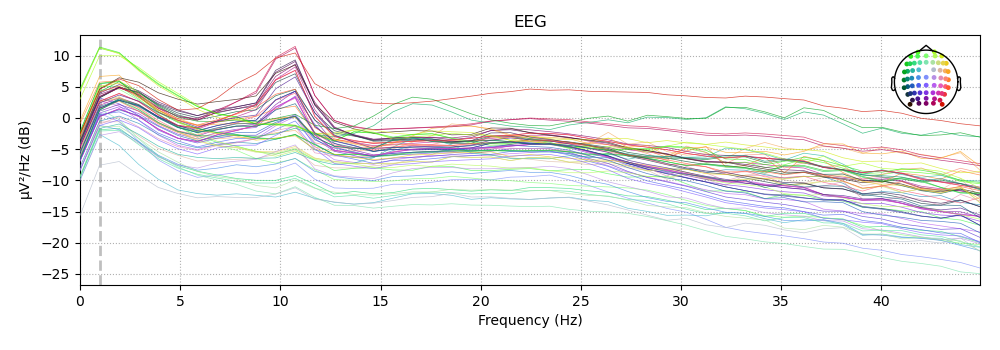

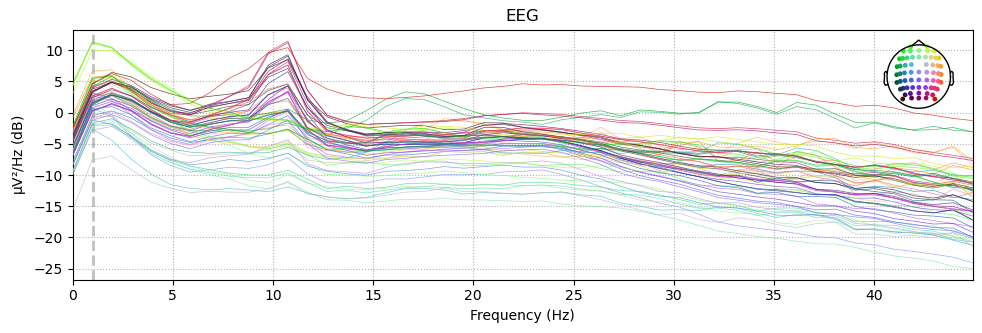

In [25]:
freq_res = 1
nfft = (2 ** np.ceil(np.log2(raw.info['sfreq'] / freq_res))).astype(int)
raw.plot_psd(fmin=0, fmax=45, n_fft=nfft, picks='all')

In [26]:
raw.info['bads'] = [] # here you can put a list of channel names that should be excluded.

You can mark bad channels and segment using the interactive window that MNE opens for us using the `plot()` method of raw class. In order to select bad channels, you only have to click on the name of the channel at the left side of the figure, or on the time series of the channel. In order to mark bad segments, you should go to annotation mode. Press Help button to see how you can go to annotation mode. For example, for mac users, you have to press a, then type the new label name starting with BAD, let' say "BAD_SEGMENT" and add the label. Then left click on the starting point of the bad segment and drag to its end. You see that the data segment is highlighted with red. In the video below, you can see how it works on my mac. Try not to exclude a lot, but exclude the segments where an extreme muscle activity is seen. Eye blinks can be removed with ICA later. More in <a href='https://mne.tools/stable/auto_tutorials/preprocessing/plot_20_rejecting_bad_data.html#sphx-glr-auto-tutorials-preprocessing-plot-20-rejecting-bad-data-py'>this MNE tutorial</a>. <a href='https://mne.tools/stable/auto_tutorials/raw/plot_30_annotate_raw.html#sphx-glr-auto-tutorials-raw-plot-30-annotate-raw-py'>This</a> may be also helpful.

    
> **Note:** If you are using the jupyter hub and `%matplotlib notebook`, it seems that that this option won't work for you!! Then, you have to load the raw object that I saved with bad segment annotations:
    
        raw = mne.io.read_raw_fif(subject + '-annotation-raw.fif')
> and then plot it and only look at the bad segments I have marked. You can look at the bad segments by sliding the grey square a long the time axis:
    
        raw.plot()

In [27]:
Video("video1.mov", width=800)

IMPORTANT NOTE: only because of the problem of having interactive figures on juputer hub of GWDG, I had to do a trick in order to provide a chance to you to select the bad segments yourself. In the cell below I define a bad segment label for the annotations and give it a length of 0. So it does not harm my data, but gives you the chance of having the label.

In [28]:
# ONLY BECAUE OF THE JUPYTERHUB: 
later_annot = mne.Annotations(onset=[0],
                              duration=[0],
                              description=['BAD_SEGMENT'])

raw = raw.set_annotations(later_annot)

Now plot your data and then make the figure larger. Then press a and then by drag and droping your mouse (left click), you can select bad segments.

Using matplotlib as 2D backend.
Opening raw-browser...


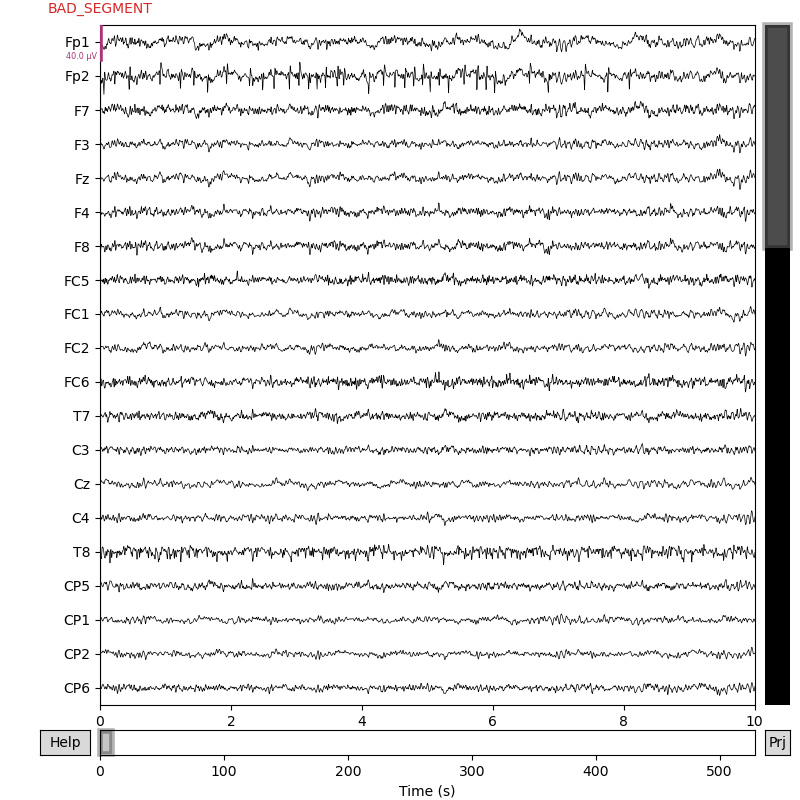

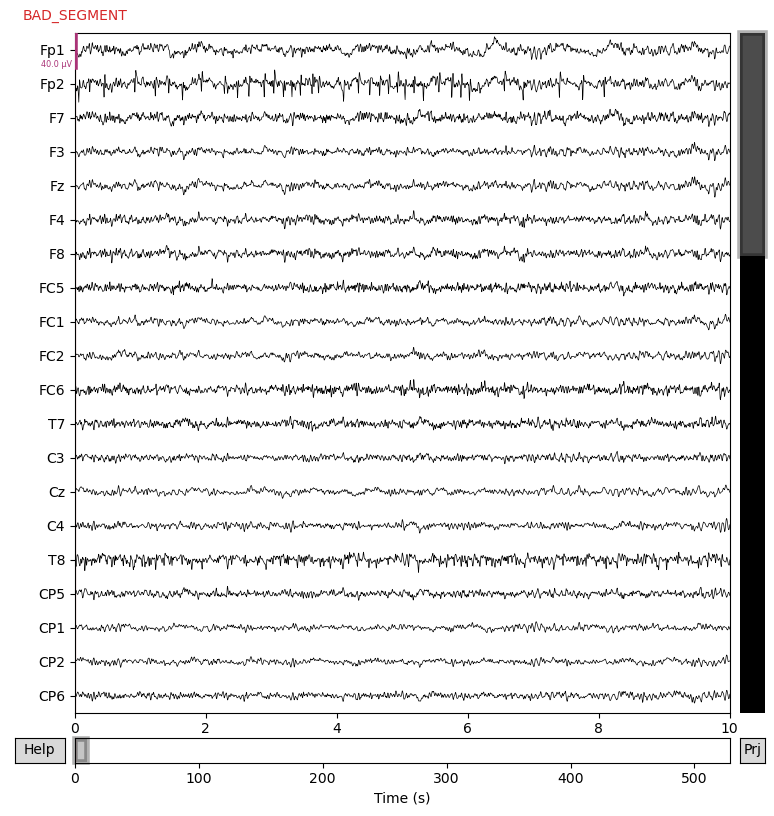

In [29]:
raw.plot()

In [30]:
print(raw._annotations)  # check the annotations
#raw_annot_fname = join('./Data', subject, subject + '-annotation-raw.fif')
#raw.save(raw_annot_fname)  # I marked the bad segments and saved it already

<Annotations | 5 segments: BAD_SEGMENT (5)>


I have marked the bad segments once, you may load it and compare it with yours. Note that if you wanna compare, load it in a variable with a name different than `raw` so that your raw object is not replaced.

In [ ]:
# raw_annot_fname = join('./Data', subject, subject + '-annotation-raw.fif')
# raw = mne.io.read_raw_fif(raw_annot_fname)

---

### References

[1] https://mne.tools/stable/index.html

[2] Babayan, A. et al. (2019) A mind-brain-body dataset of MRI, EEG, cognition, emotion, and peripheral physiology in young and old adults. Sci. Data. 6:180308 https://doi.org/10.1038/sdata.2018.308.

[3] https://mne.tools/stable/auto_tutorials/io/plot_20_reading_eeg_data.html#brainvision-vhdr-vmrk-eeg

[4] Maximilien Chaumon, Dorothy V.M. Bishop, Niko A. Busch (2015) A practical guide to the selection of independent components of the electroencephalogram for artifact correction, Journal of Neuroscience Methods, Volume 250, pp 47-63, https://doi.org/10.1016/j.jneumeth.2015.02.025.